# Extract Davis Strait section data from the VIKING20X model.

Run one year at a time


## Technical preample

In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import importlib
import sys

###  xorca_brokenline and xorca_lonlatij imported from local folder ../../src

If these are in the python environment then can import direct from there.

Note: This needs the latest (early 2022) xorca_brokenline from the repo with the fixed interpolation. **Not the latest labelled version v1.1.1**

In [2]:
# path to some plotting routines
sys.path.append(r'../../src/')

In [3]:
import xorca_brokenline as bl
from xorca_lonlat2ij import get_ij

In [4]:
from dask.distributed import Client

In [5]:
client = Client(n_workers=8, threads_per_worker=2, memory_limit=30e9, ip="0.0.0.0")
client

Client Scheduler: tcp://10.0.4.71:40979 Dashboard: http://10.0.4.71:8787/status,Cluster Workers: 8 Cores: 16 Memory: 240.00 GB


_(Click on the link above if you want to see the Dask cluster in action.)_

## Parameters

Let's make it a habit to collect everyting we might want to change at a later point (the parameters of the analysis) in a central place.

In [6]:
# paramters

# Project path
path_project = Path.cwd() / '..' / '..' 
path_project = path_project.resolve()

# Section data file
path_data_output = path_project / 'data/interim/sections'

# path to viking20 data
global_data_path = Path("/gxfs_work1/geomar/smomw355/model_data/ocean-only/")
experiment_id = "VIKING20X.L46-KKG36107B"
nest_prefix = "1"


mean_period = "1m"
year = 1990

In [7]:
yearstr = str(year)

## Load VIKING20X data

We'll first find all the relevant files and then open them as a virtual contiguous dataset.

In [8]:
U_files = (global_data_path / experiment_id / "nemo/output/").glob(f"{nest_prefix}_{experiment_id}_{mean_period}_{yearstr}????_{yearstr}????_grid_U.nc")
U_files = list(sorted(U_files))
print(f"found {len(U_files)} grid-U files")

V_files = (global_data_path / experiment_id / "nemo/output/").glob(f"{nest_prefix}_{experiment_id}_{mean_period}_{yearstr}????_{yearstr}????_grid_V.nc")
V_files = list(sorted(V_files))
print(f"found {len(V_files)} grid-V files")

T_files = (global_data_path / experiment_id / "nemo/output/").glob(f"{nest_prefix}_{experiment_id}_{mean_period}_{yearstr}????_{yearstr}????_grid_T.nc")
T_files = list(sorted(T_files))
print(f"found {len(T_files)} grid-T files")

mesh_hgr_files = (global_data_path / experiment_id / "nemo/suppl/").glob(f"{nest_prefix}_mesh_hgr*.nc")
mesh_hgr_files = list(sorted(mesh_hgr_files))
print(f"found {len(mesh_hgr_files)} mesh_hgr files")

mesh_zgr_files = (global_data_path / experiment_id / "nemo/suppl/").glob(f"{nest_prefix}_mesh_zgr*.nc")
mesh_zgr_files = list(sorted(mesh_zgr_files))
print(f"found {len(mesh_zgr_files)} mesh_zgr files")

mask_files = (global_data_path / experiment_id / "nemo/suppl/").glob(f"{nest_prefix}_mask*.nc")
mask_files = list(sorted(mask_files))
print(f"found {len(mask_files)} mask files")

mesh_mask_files = (global_data_path / experiment_id / "nemo/suppl/").glob(f"{nest_prefix}_mesh_mask*.nc")
mesh_mask_files = list(sorted(mesh_mask_files))
print(f"found {len(mesh_mask_files)} mesh mask files")


found 1 grid-U files
found 1 grid-V files
found 1 grid-T files
found 0 mesh_hgr files
found 0 mesh_zgr files
found 0 mask files
found 1 mesh mask files


In [9]:
gridU = xr.open_mfdataset(
    U_files,
    chunks={
        "time_counter": 1, "depthu": 64,
        "y": 256, "x": 1024
    },
    combine='by_coords'
)
gridV = xr.open_mfdataset(
    V_files,
    chunks={
        "time_counter": 1, "depthv": 64,
        "y": 256, "x": 1024
    },
    combine='by_coords'
)
gridT = xr.open_mfdataset(
    T_files,
    chunks={
        "time_counter": 1, "deptht": 64,
        "y": 256, "x": 1024
    },
    combine='by_coords'
)
# gridU = xr.open_dataset(gridU_files[0])
# gridV = xr.open_dataset(gridV_files[0])
mesh_mask = xr.open_dataset(mesh_mask_files[0],
    chunks={
        "z": 64,
        "y": 256, "x": 1024
    },
)
mesh_mask["e3t"] = mesh_mask["e3t_0"]
mesh_mask["e3u"] = mesh_mask["e3u_0"]
mesh_mask["e3v"] = mesh_mask["e3v_0"]
mesh_mask["e3w"] = mesh_mask["e3w_0"]

mesh_hgr = mesh_mask
# mesh_hgr = xr.open_dataset(mesh_hgr_files[0],    
#     chunks={
#         "t": 1, "z": 64,
#         "y": 256, "x": 1024
#     },
# )
mesh_zgr = mesh_mask
# mesh_zgr = xr.open_dataset(mesh_zgr_files[0],
#     chunks={
#         "t": 1, "z": 64,
#         "y": 256, "x": 1024
#     },
# )
mask = mesh_mask
# mask = xr.open_dataset(mask_files[0],
#     chunks={
#         "t": 1, "z": 64,
#         "y": 256, "x": 1024
#     },
# )


fmask = mask['fmask'].isel(t=0,z=0)


## Define a section and find grid points along the section

This is a simple section along y=2496.

In [10]:
vertices_ji = np.array([[2496,750],
 [2496,  1050]])



### slice viking20x datafiles for speed

In [11]:
gridT= gridT.isel(x=slice(650,1200,1),y=slice(2400,None,1))

In [12]:
gridU = gridU.isel(x=slice(650,1200,1),y=slice(2400,None,1))
gridV = gridV.isel(x=slice(650,1200,1),y=slice(2400,None,1))
mesh_hgr = mesh_hgr.isel(x=slice(650,1200,1),y=slice(2400,None,1))
mesh_zgr= mesh_zgr.isel(x=slice(650,1200,1),y=slice(2400,None,1))
mask = mask.isel(x=slice(650,1200,1),y=slice(2400,None,1))
mesh_mask = mesh_mask .isel(x=slice(650,1200,1),y=slice(2400,None,1))


In [13]:
fmask = mask['fmask'].isel(t=0,z=0)

In [14]:
vertices_ji = vertices_ji - np.array([2400,650])
print(vertices_ji)

[[ 96 100]
 [ 96 400]]


In [15]:
ji_pairs = vertices_ji

## Extract Section
bl.shift_grids() interpolates all variables onto the u- and v-points, drops unnecessary coordinate labels and variables and renames depth dimension. <br>
select_section() selects the section defined by ji from gridU_processed and gridV_processed and returns a section.


In [16]:
ji = bl.section_indices(ji_pairs=ji_pairs)

In [17]:
# gridU_processed, gridV_processed = bl.shift_grids(gridU=gridU, gridV=gridV)
gridU_processed, gridV_processed = bl.shift_grids(gridU=gridU, gridV=gridV, mesh_hgr=mesh_hgr,mesh_zgr=mesh_zgr,mask=mask,gridT=gridT)

In [18]:
%%time

section = bl.select_section(ji,gridU_processed,gridV_processed,mesh_hgr,mesh_zgr,mask).compute()
# reverse direction of normal velocities
section['u_normal']=-section['u_normal']

CPU times: user 3.64 s, sys: 187 ms, total: 3.83 s
Wall time: 8.54 s


Section includes the velocity normal to the section (either U or V, depending on the orientation of each segment), the length and depth of each segment and a land-sea mask variable. 

In [19]:
!mkdir -p {str(path_data_output)}

In [20]:
filename_output = 'sectionDAVIS_' + mean_period + '_' + yearstr + '.nc'

section.to_netcdf(path_data_output / filename_output)

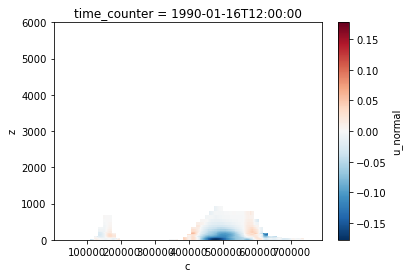

In [21]:
section.u_normal.isel(time_counter=0).plot()